In [227]:
from sklearn.cluster import DBSCAN
import numpy as np


In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
# import numpy as np
import pandas as pd

In [237]:
from create_matrix import *
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os
from degree_days import dds
import autograd.numpy as np




def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [150]:
def get_tensor(df):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    dfc = df.copy()

    df = dfc[energy_cols]

    tensor = df.values.reshape((len(df), 7, stop - start))
    return tensor


def create_region_df_dfc_static(region, year):
    df, dfc = create_matrix_single_region(region, year)
    tensor = get_tensor(df)
    static_region = df[['area', 'total_occupants', 'num_rooms']].copy()
    static_region['area'] = static_region['area'].div(4000)
    static_region['total_occupants'] = static_region['total_occupants'].div(8)
    static_region['num_rooms'] = static_region['num_rooms'].div(8)
    static_region =static_region.values
    return df, dfc, tensor, static_region


In [151]:
au_df, au_dfc, au_tensor, au_static = create_region_df_dfc_static('Austin', year)
sd_df, sd_dfc, sd_tensor, sd_static = create_region_df_dfc_static('SanDiego', year)

In [16]:
sd_agg = sd_df.loc[:, 'aggregate_1':'aggregate_12']
au_agg = au_df.loc[:, 'aggregate_1':'aggregate_12']

In [19]:
sd_agg = np.nan_to_num(sd_agg)
au_agg = np.nan_to_num(au_agg)

In [35]:
def distance(x, y):
    return np.linalg.norm(x - y)

In [226]:
def get_L_DBSCAN(X):
    db = DBSCAN(eps=500, min_samples=1, metric=distance).fit(X)
    labels = db.labels_
    n_sample, n_feature = X.shape
    W = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        label = labels[i]
        neighbours = [j for j,x in enumerate(labels) if x == label]
        for k in neighbours:
            W[i][k] = 1
    K = np.dot(W, np.ones((n_sample, n_sample)))        
    D = np.diag(np.diag(K))
    return D-W

In [218]:
from sklearn.neighbors import NearestNeighbors
def get_L_NN(X):
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    n_sample, n_feature = X.shape
    W = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        for j in indices[i]:
            W[i][j] = 1
            W[j][i] = 1
    K = np.dot(W, np.ones((n_sample, n_sample)))
    D = np.diag(np.diag(K))
    return D - W

In [133]:
def cost_graph_laplacian(H, A, T, F, L, E_np_masked, K, lam1, lam2, case):
    HAT = multiply_case(H, A, T, case)
    mask = ~np.isnan(E_np_masked)
    error_1 = (HAT - E_np_masked)[mask].flatten()
    
    HF = np.einsum('na, ab->nb', H, F)
    mask_static = ~np.isnan(k)
    error_2 = (HF - K)[mask_static].flatten()
    
    HTL = np.dot(H.T, L)
    HTLH = np.dot(HTL, H)
    error_3 = np.trace(HTLH)
    
    return np.sqrt((error_1**2).mean()) + lam1 * np.sqrt((error_2**2).mean()) + lam2 * error_3

In [136]:
mg = multigrad(cost_graph_laplacian, argnums=[0, 1, 2, 3])

H = np.random.rand(n_sample_sd, 3)
A = np.random.rand(7, 3, 3)
T = np.random.rand(12, 3)
F = np.random.rand(3, 12)
del_h, del_a, del_t, del_f = mg(H, A, T, F, L_sd, sd_tensor, sd_agg, 1, 1, 2)

In [138]:
def learn_HAT_adagrad_graph(case, E_np_masked, L, K, a, b, num_iter=2000, lr=0.1, dis=False, lam1 = 1, lam2 = 1, H_known=None,
                      A_known=None, T_known=None, random_seed=0, eps=1e-8, penalty_coeff=0.0):

    cost = cost_graph_laplacian
    mg = multigrad(cost, argnums=[0, 1, 2, 3])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    
    H = np.random.rand(*H_dim)
    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)
    F = np.random.rand(a, 12)

    sum_square_gradients_H = np.zeros_like(H)
    sum_square_gradients_A = np.zeros_like(A)
    sum_square_gradients_T = np.zeros_like(T)
    sum_square_gradients_F = np.zeros_like(F)

    Hs = [H.copy()]
    As = [A.copy()]
    Ts = [T.copy()]
    Fs = [F.copy()]
    
    costs = [cost(H, A, T, F, L, E_np_masked, K, lam1, lam2, case)]
    
#     if 'penalty' not in cost_function:
#         costs = [cost(H, A, T, H_1, F, E_np_masked, static, case)]
#     else:
#         costs = [cost(H, A, T, E_np_masked, 2, penalty_coeff)]
    HATs = [multiply_case(H, A, T, case)]

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t, del_f = mg(H, A, T, F, L, E_np_masked, K, lam1, lam2, case)
        sum_square_gradients_H += eps + np.square(del_h)
        sum_square_gradients_A += eps + np.square(del_a)
        sum_square_gradients_T += eps + np.square(del_t)
        sum_square_gradients_F += eps + np.square(del_f)

        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        lr_t = np.divide(lr, np.sqrt(sum_square_gradients_T))
        lr_f = np.divide(lr, np.sqrt(sum_square_gradients_F))

        H -= lr_h * del_h
        A -= lr_a * del_a
        T -= lr_t * del_t
        F -= lr_f * del_f
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 1e-8
        A[A < 0] = 1e-8
        T[T < 0] = 1e-8
        F[F < 0] = 1e-8

        As.append(A.copy())
        Ts.append(T.copy())
        Hs.append(H.copy())
        Fs.append(F.copy())
        
        costs.append(cost(H, A, T, F, L, E_np_masked, K, lam1, lam2, case))
        
#         if 'penalty' not in cost_function:
#             costs.append(cost(H, A, T, H_1, F, E_np_masked, static, case))
#         else:
#             costs.append(cost(H, A, T, F, E_np_masked, static, case))
        HATs.append(multiply_case(H, A, T, case))
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, F, L, E_np_masked, K, lam1, lam2, case))
    return H, A, T, F, Hs, As, Ts, Fs, HATs, costs

In [198]:
def cost_graph_laplacian_2(H, A, T, H_f, F, L, E_np_masked, K, lam1, lam2, case):
    HAT = multiply_case(H, A, T, case)
    mask = ~np.isnan(E_np_masked)
    error_1 = (HAT - E_np_masked)[mask].flatten()
    
    HF = np.einsum('na, ab->nb', H_f, F)
    mask_static = ~np.isnan(k)
    error_2 = (HF - K)[mask_static].flatten()
    
    HTL = np.dot(H_f.T, L)
    HTLH = np.dot(HTL, H_f)
    error_3 = np.trace(HTLH)
    
    return np.sqrt((error_1**2).mean()) + lam1 * np.sqrt((error_2**2).mean()) + lam2 * error_3

In [202]:
def learn_HAT_adagrad_graph_2(case, E_np_masked, L, K, a, b, c, num_iter=2000, lr=0.1, dis=False, lam1 = 1, lam2 = 1, H_known=None,
                      A_known=None, T_known=None, random_seed=0, eps=1e-8, penalty_coeff=0.0):

    cost = cost_graph_laplacian_2
    mg = multigrad(cost, argnums=[0, 1, 2, 3, 4])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    
    H = np.random.rand(*H_dim)
    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)
    H_f = np.random.rand(params['M'], c)
    F = np.random.rand(c, 12)

    sum_square_gradients_H = np.zeros_like(H)
    sum_square_gradients_A = np.zeros_like(A)
    sum_square_gradients_T = np.zeros_like(T)
    sum_square_gradients_H_f = np.zeros_like(H_f)
    sum_square_gradients_F = np.zeros_like(F)

    Hs = [H.copy()]
    As = [A.copy()]
    Ts = [T.copy()]
    H_fs = [H_f.copy()]
    Fs = [F.copy()]
    
    costs = [cost(H, A, T, H_f, F, L, E_np_masked, K, lam1, lam2, case)]
    
#     if 'penalty' not in cost_function:
#         costs = [cost(H, A, T, H_1, F, E_np_masked, static, case)]
#     else:
#         costs = [cost(H, A, T, E_np_masked, 2, penalty_coeff)]
    HATs = [multiply_case(H, A, T, case)]

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t, del_h_f, del_f = mg(H, A, T, H_f, F, L, E_np_masked, K, lam1, lam2, case)
        sum_square_gradients_H += eps + np.square(del_h)
        sum_square_gradients_A += eps + np.square(del_a)
        sum_square_gradients_T += eps + np.square(del_t)
        sum_square_gradients_H_f += eps + np.square(del_h_f)
        sum_square_gradients_F += eps + np.square(del_f)

        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        lr_t = np.divide(lr, np.sqrt(sum_square_gradients_T))
        lr_h_f = np.divide(lr, np.sqrt(sum_square_gradients_H_f))
        lr_f = np.divide(lr, np.sqrt(sum_square_gradients_F))

        H -= lr_h * del_h
        A -= lr_a * del_a
        T -= lr_t * del_t
        H_f -= lr_h_f * del_h_f
        F -= lr_f * del_f
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        H = set_known(H, H_f)
        # Projection to non-negative space
        H[H < 0] = 1e-8
        A[A < 0] = 1e-8
        T[T < 0] = 1e-8
        H_f[H_f < 0] = 1e-8
        F[F < 0] = 1e-8

        As.append(A.copy())
        Ts.append(T.copy())
        Hs.append(H.copy())
        H_fs.append(H_f.copy())
        Fs.append(F.copy())
        
        costs.append(cost(H, A, T, H_f, F, L, E_np_masked, K, lam1, lam2, case))
        
#         if 'penalty' not in cost_function:
#             costs.append(cost(H, A, T, H_1, F, E_np_masked, static, case))
#         else:
#             costs.append(cost(H, A, T, F, E_np_masked, static, case))
        HATs.append(multiply_case(H, A, T, case))
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, H_f, F, L, E_np_masked, K, lam1, lam2, case))
    return H, A, T, H_f, F, Hs, As, Ts, H_fs, Fs, HATs, costs

In [206]:
def cost_graph_laplacian_3(H, A, T, L, E_np_masked, lam, case):
    HAT = multiply_case(H, A, T, case)
    mask = ~np.isnan(E_np_masked)
    error_1 = (HAT - E_np_masked)[mask].flatten()
    
    HTL = np.dot(H.T, L)
    HTLH = np.dot(HTL, H)
    error_2 = np.trace(HTLH)
    
    return np.sqrt((error_1**2).mean()) + lam * error_2

In [250]:
def learn_HAT_adagrad_graph_3(case, E_np_masked, L, a, b, num_iter=2000, lr=0.1, dis=False, lam = 1, H_known=None,
                      A_known=None, T_known=None, random_seed=0, eps=1e-8, penalty_coeff=0.0):

    cost = cost_graph_laplacian_3
    mg = multigrad(cost, argnums=[0, 1, 2])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    
    H = np.random.rand(*H_dim)
    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)

    sum_square_gradients_H = np.zeros_like(H)
    sum_square_gradients_A = np.zeros_like(A)
    sum_square_gradients_T = np.zeros_like(T)

    Hs = [H.copy()]
    As = [A.copy()]
    Ts = [T.copy()]
    
    costs = [cost(H, A, T, L, E_np_masked, lam, case)]
    
#     if 'penalty' not in cost_function:
#         costs = [cost(H, A, T, H_1, F, E_np_masked, static, case)]
#     else:
#         costs = [cost(H, A, T, E_np_masked, 2, penalty_coeff)]
    HATs = [multiply_case(H, A, T, case)]

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, L, E_np_masked, lam, case)
        sum_square_gradients_H += eps + np.square(del_h)
        sum_square_gradients_A += eps + np.square(del_a)
        sum_square_gradients_T += eps + np.square(del_t)

        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        lr_t = np.divide(lr, np.sqrt(sum_square_gradients_T))

        H -= lr_h * del_h
        A -= lr_a * del_a
        T -= lr_t * del_t
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 1e-8
        A[A < 0] = 1e-8
        T[T < 0] = 1e-8

        As.append(A.copy())
        Ts.append(T.copy())
        Hs.append(H.copy())
        
        costs.append(cost(H, A, T, L, E_np_masked, lam, case))
        
#         if 'penalty' not in cost_function:
#             costs.append(cost(H, A, T, H_1, F, E_np_masked, static, case))
#         else:
#             costs.append(cost(H, A, T, F, E_np_masked, static, case))
        HATs.append(multiply_case(H, A, T, case))
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, L, E_np_masked, lam, case))
    return H, A, T, Hs, As, Ts, HATs, costs

In [219]:
a = 5
b = 3
c = 3
L_au = get_L_NN(au_agg)
H_au_2, A_au_2, T_au_2, F_au, Hs, As, Ts, Fs, HATs, costs = learn_HAT_adagrad_graph_2(case, au_tensor, L_au, au_agg, a, b, c, num_iter=2000, lr=0.1, dis=True, random_seed=0, eps=1e-8, penalty_coeff=0.0)

H_au_3, A_au_3, T_au_3, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph_3(case, au_tensor, L_au, a, b, num_iter=2000, lr=0.1, dis=True, random_seed=0, eps=1e-8, penalty_coeff=0.0)



1733.34341802
1002.7556091
956.086922846
942.479788446
1166.87000311
271.119788994
180.348376079
170.271761619


In [220]:
HAT_2 = multiply_case(H_au_2, A_au_2, T_au_2, case)
HAT_3 = multiply_case(H_au_3, A_au_3, T_au_3, case)

In [221]:
pred_2 = {}

for appliance_name, appliance_id in appliance_index.iteritems():
    pred_2[appliance_name] = []
    pred_2[appliance_name].append(pd.DataFrame(HAT_2[:,appliance_id,:], index=au_df.index))

In [222]:
pred_3 = {}

for appliance_name, appliance_id in appliance_index.iteritems():
    pred_3[appliance_name] = []
    pred_3[appliance_name].append(pd.DataFrame(HAT_3[:,appliance_id,:], index=au_df.index))

In [223]:
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse
from common import compute_rmse_fraction
out_2 = {}
out_3 = {}

for appliance in APPLIANCES_ORDER[1:]:
    out_2[appliance] = {}
    out_3[appliance] = {}
    s_2 = pd.concat(pred_2[appliance]).ix[au_df.index]
    s_3 = pd.concat(pred_3[appliance]).ix[au_df.index]
    if appliance=="hvac":
        out_2[appliance] = compute_rmse_fraction(appliance,s_2[range(4, 10)],'Austin')[2]
        out_3[appliance] = compute_rmse_fraction(appliance,s_3[range(4, 10)],'Austin')[2]
    else:   
        out_2[appliance] = compute_rmse_fraction(appliance, s_2,'Austin')[2]
        out_3[appliance] = compute_rmse_fraction(appliance, s_3,'Austin')[2]

/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


In [225]:
out_3

{'dw': 1.3107564439819674,
 'fridge': 4.3697154486826975,
 'hvac': 18.631982426244011,
 'mw': 1.5619083169414467,
 'oven': 1.4720133009223535,
 'wm': 0.60252214620656741}

In [217]:
out_3

{'dw': 1.4025844525773852,
 'fridge': 4.2662321721176459,
 'hvac': 24.223365053157096,
 'mw': 1.4841294768556004,
 'oven': 1.5871422614779043,
 'wm': 0.58995752075905894}

In [249]:
n_splits = 10
case = 2
a = 5
b = 3
c = 3
iters = 2000

# H_au, A_au, T_au, F_au = learn_HAT_graph(2, au_tensor, static_au, sim_au, a, b, num_iter=iters, dis=True, T_known = np.ones(12).reshape(-1, 1))
L_au = get_L(au_agg)
L_sd = get_L(sd_agg)
H_au, A_au, T_au, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph_3(case, au_tensor, L_au, a, b, num_iter=2000, lr=0.1, dis=True, T_known = np.ones(12).reshape(-1, 1))

pred_normal = {}
pred_transfer = {}
for random_seed in range(5):
    pred_normal[random_seed] = {}
    pred_transfer[random_seed] = {}
    
    for appliance in APPLIANCES_ORDER:
        pred_normal[random_seed][appliance] = {f:[] for f in range(10, 110, 20)}
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 20)}

kf = KFold(n_splits=n_splits)
for random_seed in range(5):
    print "random seed: ", random_seed
    np.random.seed(random_seed)
    for train_percentage in range(10, 110, 20):
        print "training percentage: ", train_percentage
        rd = 0
        
        for train_max, test in kf.split(sd_df):
            print "round: ", rd
           
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            print test, train
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t)
            
            ############################################################################################
            # Normal learning: no constant constraint, no A_known, with learn_HAT
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            agg = sd_agg[np.concatenate([test, train])]
            L = L_sd[np.ix_(np.concatenate([test, train]), np.concatenate([test, train]))]
            
#             H, A, T, F = learn_HAT_graph(2, tensor_copy, static_sd[np.concatenate([test, train])], sim_sd, a, b, num_iter=iters,dis=True, T_known = np.ones(12).reshape(-1, 1))
            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph_3(case, tensor_copy, L, a, b, num_iter=400, lr=1, dis=True, T_known = np.ones(12).reshape(-1, 1))


            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_normal[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
                       
            
            ############################################################################################
            # transfer learning: constant constraint, with A_known = A_a_const, with learn_HAT_constant
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            agg = sd_agg[np.concatenate([test, train])]
            L = L_sd[np.ix_(np.concatenate([test, train]), np.concatenate([test, train]))]
            
#             H, A, T, F = learn_HAT_graph(2, tensor_copy, static_sd[np.concatenate([test, train])], sim_sd, a, b, num_iter=iters,dis=True, T_known = np.ones(12).reshape(-1, 1))
#             H, A, T, F, Hs, As, Ts, Fs, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, L, agg, a, b, num_iter=20000, lr=0.1, dis=True,A_known = A_au)
            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph_3(case, tensor_copy, L, a, b, num_iter=400, lr=1, dis=True, A_known = A_au, T_known = np.ones(12).reshape(-1, 1))

      
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_transfer[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
            
            rd += 1

29103.2501488
433.721481286
373.179224669
333.483950339
311.054709825
297.473001416
288.426347706


KeyboardInterrupt: 

In [245]:
out = {}

out_normal = {}
out_transfer = {}

for random_seed in range(1):
    out_normal[random_seed] = {}   
    for appliance in APPLIANCES_ORDER[1:]:
        out_normal[random_seed][appliance] = {}
        for f in range(10,20,10):
            s = pd.concat(pred_normal[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_normal[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_normal[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]
for random_seed in range(1):
    out_transfer[random_seed] = {}   
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer[random_seed][appliance] = {}
        for f in range(10,20,10):
            s = pd.concat(pred_transfer[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [240]:
out_normal

{0: {'dw': {10: 2.061196915389675},
  'fridge': {10: 9.3263892758198637},
  'hvac': {10: 18.662220490470744},
  'mw': {10: 2.0718812057239089},
  'oven': {10: 2.3184478226695067},
  'wm': {10: 1.9405900037051071}}}

In [246]:
out_normal

{0: {'dw': {10: 2.2235990862943895},
  'fridge': {10: 8.8646357857077742},
  'hvac': {10: 18.059644812715565},
  'mw': {10: 2.0520399680549035},
  'oven': {10: 2.3660763492473116},
  'wm': {10: 1.6165099772954101}}}

In [241]:
out_transfer

{0: {'dw': {10: 1.9360601283297472},
  'fridge': {10: 11.25068823882877},
  'hvac': {10: 18.948528522903132},
  'mw': {10: 2.4256681454352989},
  'oven': {10: 2.454790158875316},
  'wm': {10: 1.009755443665278}}}

In [248]:
out_transfer

{0: {'dw': {10: 1.9589710852201232},
  'fridge': {10: 10.326995075865719},
  'hvac': {10: 22.178975755827633},
  'mw': {10: 2.3200847091950223},
  'oven': {10: 2.44326718010596},
  'wm': {10: 0.95822395577664388}}}

### Read from files

In [228]:
import pickle

def load_obj(name):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        try:
            return pickle.load(f)
        except EOFError:
            return None

In [251]:
transfer = load_obj("graph_test/transfer")
normal = load_obj("graph_test/normal")

In [254]:
err_t = {}
err_n = {}
for random_seed in range(5):
    err_t[random_seed] = {}
    err_n[random_seed] = {}
    for appliance in APPLIANCES_ORDER[1:]:
        err_t[random_seed][appliance] = {}
        err_n[random_seed][appliance] = {}
        for f in range(10,110,20):
            s_n = pd.concat(normal[random_seed][appliance][f]).ix[sd_df.index]
            s_t = pd.concat(transfer[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                err_t[random_seed][appliance][f] = compute_rmse_fraction(appliance,s_t[range(4, 10)],'SanDiego')[2]
                err_n[random_seed][appliance][f] = compute_rmse_fraction(appliance,s_n[range(4, 10)],'SanDiego')[2]
            else:   
                err_t[random_seed][appliance][f] = compute_rmse_fraction(appliance, s_t,'SanDiego')[2]
                err_n[random_seed][appliance][f] = compute_rmse_fraction(appliance, s_n,'SanDiego')[2]




/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


In [255]:
mean_t = pd.Panel(err_t).mean(axis=0)
mean_n = pd.Panel(err_n).mean(axis=0)

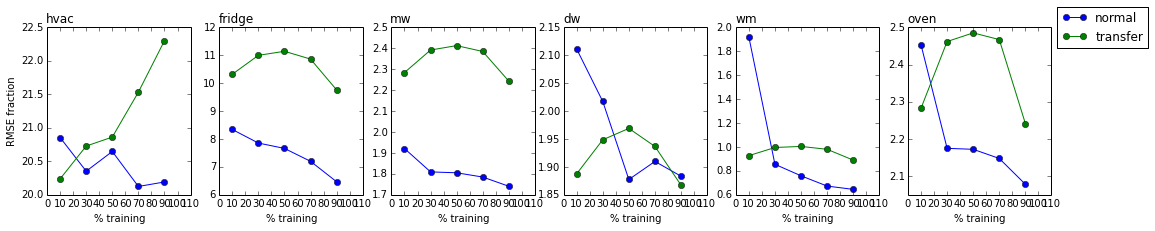

In [256]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 80))
ax = axes.flatten()
count = 0
algo = 'gd'

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
#     df1 = mean_out['normal']['feature'][appliance]
#     df2 = mean_out['normal']['None'][appliance]
#     df3 = mean_out['transfer']['feature'][appliance]
#     df4 = mean_out['transfer']['None'][appliance]
#     df = pd.concat([df1, df2, df3, df4], axis = 1)
    df1 = mean_n[appliance]
    df2 = mean_t[appliance]
    df = pd.concat([df1, df2], axis = 1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_title(appliance, loc="left")
    ax[count].legend().set_visible(False)
    count += 1
ax[0].set_ylabel('RMSE fraction')
# plt.suptitle(algo, fontsize=17,y=1.04)

# ax[count-1].legend(["normal", 'transfer'], loc='center left' , bbox_to_anchor=(1, 1))

ax[count-1].legend(["normal",'transfer'], loc='center left' , bbox_to_anchor=(1, 1))
# plt.savefig("./analysis/08/featurefactorization_all.pdf", bbox_inches="tight", dpi=300, format='pdf')

In [261]:
result = {}
pred_feature = {}
param = {}
for method in ['normal', 'transfer']:
    pred_feature[method] = {}
    param[method] = {}
    for feature_fac in ['feature', 'None']:
        pred_feature[method][feature_fac] = {}
        param[method][feature_fac] = {}
        for random_seed in range(5):
            pred_feature[method][feature_fac][random_seed] = {}
            param[method][feature_fac][random_seed] = {}
            for train_percentage in range(10, 110, 20):
                name = "pred_feature_1/{}_{}/{}-{}-{}".format(method, feature_fac, feature_fac, random_seed, float(train_percentage))
                print name
                r = load_obj(name)
                pred_feature[method][feature_fac][random_seed][train_percentage] = r['Predictions']
                param[method][feature_fac][random_seed][train_percentage] = r['Learning Params']

pred_feature_1/normal_feature/feature-0-10.0
pred_feature_1/normal_feature/feature-0-30.0
pred_feature_1/normal_feature/feature-0-50.0
pred_feature_1/normal_feature/feature-0-70.0
pred_feature_1/normal_feature/feature-0-90.0
pred_feature_1/normal_feature/feature-1-10.0
pred_feature_1/normal_feature/feature-1-30.0
pred_feature_1/normal_feature/feature-1-50.0
pred_feature_1/normal_feature/feature-1-70.0
pred_feature_1/normal_feature/feature-1-90.0
pred_feature_1/normal_feature/feature-2-10.0
pred_feature_1/normal_feature/feature-2-30.0
pred_feature_1/normal_feature/feature-2-50.0
pred_feature_1/normal_feature/feature-2-70.0
pred_feature_1/normal_feature/feature-2-90.0
pred_feature_1/normal_feature/feature-3-10.0
pred_feature_1/normal_feature/feature-3-30.0
pred_feature_1/normal_feature/feature-3-50.0
pred_feature_1/normal_feature/feature-3-70.0
pred_feature_1/normal_feature/feature-3-90.0
pred_feature_1/normal_feature/feature-4-10.0
pred_feature_1/normal_feature/feature-4-30.0
pred_featu

In [262]:
out_feature= {}
for method in ['normal', 'transfer']:
    out_feature[method] = {}
    for feature_fac in ['feature', 'None']:
        out_feature[method][feature_fac] = {}
        for random_seed in range(5):
            out_feature[method][feature_fac][random_seed] = {}
            for appliance in APPLIANCES_ORDER[1:]:
                out_feature[method][feature_fac][random_seed][appliance] = {}
                for f in range(10,110,20):
#                     s = pd.concat(pred_feature[method][feature_fac][random_seed][appliance][f]).ix[sd_df.index]
                    s = pred_feature[method][feature_fac][random_seed][f][appliance]
                    if appliance=="hvac":
                        out_feature[method][feature_fac][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                    else:   
                        out_feature[method][feature_fac][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]      

In [263]:
result = {}
pred_graph = {}
param = {}
for method in ['normal', 'transfer']:
    pred_graph[method] = {}
    param[method] = {}
    for random_seed in range(5):
        pred_graph[method][random_seed] = {}
        param[method][random_seed] = {}
        for train_percentage in range(10, 110, 20):
            name = "pred_graph/{}/{}-{}".format(method, random_seed, float(train_percentage))
            print name
            r = load_obj(name)
            pred_graph[method][random_seed][train_percentage] = r['Predictions']
            param[method][random_seed][train_percentage] = r['Learning Params']

pred_graph/normal/0-10.0
pred_graph/normal/0-30.0
pred_graph/normal/0-50.0
pred_graph/normal/0-70.0
pred_graph/normal/0-90.0
pred_graph/normal/1-10.0
pred_graph/normal/1-30.0
pred_graph/normal/1-50.0
pred_graph/normal/1-70.0
pred_graph/normal/1-90.0
pred_graph/normal/2-10.0
pred_graph/normal/2-30.0
pred_graph/normal/2-50.0
pred_graph/normal/2-70.0
pred_graph/normal/2-90.0
pred_graph/normal/3-10.0
pred_graph/normal/3-30.0
pred_graph/normal/3-50.0
pred_graph/normal/3-70.0
pred_graph/normal/3-90.0
pred_graph/normal/4-10.0
pred_graph/normal/4-30.0
pred_graph/normal/4-50.0
pred_graph/normal/4-70.0
pred_graph/normal/4-90.0
pred_graph/transfer/0-10.0
pred_graph/transfer/0-30.0
pred_graph/transfer/0-50.0
pred_graph/transfer/0-70.0
pred_graph/transfer/0-90.0
pred_graph/transfer/1-10.0
pred_graph/transfer/1-30.0
pred_graph/transfer/1-50.0
pred_graph/transfer/1-70.0
pred_graph/transfer/1-90.0
pred_graph/transfer/2-10.0
pred_graph/transfer/2-30.0
pred_graph/transfer/2-50.0
pred_graph/transfer/2-70

In [264]:
out_graph= {}
for method in ['normal', 'transfer']:
    out_graph[method] = {}
    for random_seed in range(5):
        out_graph[method][random_seed] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            out_graph[method][random_seed][appliance] = {}
            for f in range(10,110,20):
#                     s = pd.concat(pred[method][feature_fac][random_seed][appliance][f]).ix[sd_df.index]
                s = pred_graph[method][random_seed][f][appliance]
                if appliance=="hvac":
                    out_graph[method][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                else:   
                    out_graph[method][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]
            

In [265]:
mean_out_feature = {}
for method in ['normal', 'transfer']:
    mean_out_feature[method] = {}
    for feature_fac in ['feature', 'None']:
        mean_out_feature[method][feature_fac] = pd.Panel(out_feature[method][feature_fac]).mean(axis=0)

In [266]:
mean_out_graph = {}
for method in ['normal', 'transfer']:
    mean_out_graph[method] = pd.Panel(out_graph[method]).mean(axis=0)

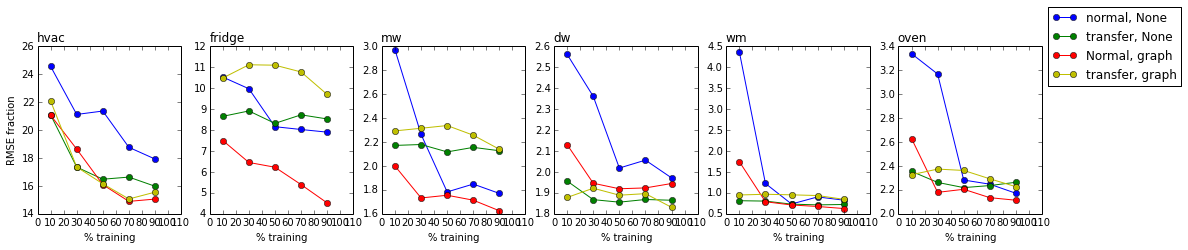

In [271]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 80))
ax = axes.flatten()
count = 0
algo = 'gd'

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = mean_out_feature['normal']['feature'][appliance]
    df2 = mean_out_feature['normal']['None'][appliance]
    df3 = mean_out_feature['transfer']['feature'][appliance]
    df4 = mean_out_feature['transfer']['None'][appliance]
#     df = pd.concat([df1, df2, df3, df4], axis = 1)
    df5 = mean_out_graph['normal'][appliance]
    df6 = mean_out_graph['transfer'][appliance]
    df = pd.concat([df2, df4, df5, df6], axis = 1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_title(appliance, loc="left")
    ax[count].legend().set_visible(False)
    count += 1
ax[0].set_ylabel('RMSE fraction')
# plt.suptitle(algo, fontsize=17,y=1.04)

# ax[count-1].legend(["normal", 'transfer'], loc='center left' , bbox_to_anchor=(1, 1))

ax[count-1].legend(["normal, None",'transfer, None', 'Normal, graph', 'transfer, graph'], loc='center left' , bbox_to_anchor=(1, 1))
plt.savefig("./analysis/08/graph_normal_transfer_all.pdf", bbox_inches="tight", dpi=300, format='pdf')